In [1]:
# status initialize
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import os
import random
import fnmatch
import datetime
import pickle
import numpy as np
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

import pandas as pd
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

print('tf.__version__:', tf.__version__)
print('keras__version__:', tf.keras.__version__)

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#import colab
#from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mping
from PIL import Image

tf.__version__: 1.15.3
keras__version__: 2.2.4-tf


image_paths ['crop_img/train_02256_002.png', 'crop_img/train_01903_000.png', 'crop_img/train_02200_001.png', 'crop_img/train_02909_000.png', 'crop_img/train_00163_000.png', 'crop_img/train_00138_000.png', 'crop_img/train_00261_000.png', 'crop_img/train_02994_000.png', 'crop_img/train_02492_000.png', 'crop_img/train_01891_000.png', 'crop_img/train_02778_000.png', 'crop_img/train_03183_000.png', 'crop_img/train_03267_001.png', 'crop_img/train_01809_001.png', 'crop_img/train_01072_000.png', 'crop_img/train_02046_000.png', 'crop_img/train_00405_000.png', 'crop_img/train_03098_001.png', 'crop_img/train_00468_000.png', 'crop_img/train_01434_000.png', 'crop_img/train_01510_000.png', 'crop_img/train_02795_001.png', 'crop_img/train_02281_000.png', 'crop_img/train_03241_000.png', 'crop_img/train_02891_000.png', 'crop_img/train_00773_000.png', 'crop_img/train_01576_000.png', 'crop_img/train_00537_000.png', 'crop_img/train_01209_000.png', 'crop_img/train_03278_001.png', 'crop_img/train_02963_000.p

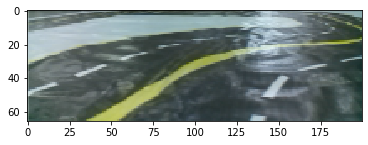

In [3]:
data_dir = "crop_img"
file_list = os.listdir(data_dir)
image_paths = []
steering_angles = []
pattern ="*.png"
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(data_dir, filename))
        angle = int(filename[-7:-4])
        steering_angles.append(angle)
print('image_paths', image_paths)
print('steering_angles', steering_angles)
image_index = 1
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: ", image_paths[image_index])
print("steering_Angle: ", steering_angles[image_index])
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles

[2018    0    0    0    0  743    0    0    0  531]
[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2. ]


(array([2018.,    0.,    0.,    0.,    0.,  743.,    0.,    0.,    0.,
         531.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

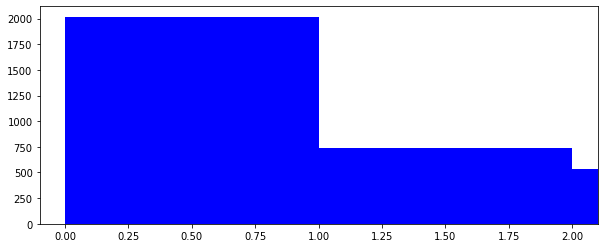

In [4]:
num_of_bins = 10
hist, bins = np.histogram(df['Angle'], num_of_bins)
print(hist)
print(bins)
fig, axes = plt.subplots(1,1,figsize=(10,4))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')

In [5]:
'''s = np.array(steering_angles)
angle0=np.where(s==0)
print(angle0)
angle0=np.where(s==45)
print(angle0)
angle0=np.where(s==90)
print(angle0)
angle0=np.where(s==135)
print(angle0)'''

s = np.array(steering_angles)
new_angles = np.copy(steering_angles)
new_angles[np.where(s==0)] = 0
new_angles[np.where(s==45)] = 1
new_angles[np.where(s==135)] = 2
print(new_angles)
print(steering_angles)
print(len(np.where(new_angles==0)[0]))
print(len(np.where(new_angles==1)[0]))
print(len(np.where(new_angles==2)[0]))
#print(len(new_angles))
df['Angle'] = new_angles

[2 0 1 ... 0 1 2]
[2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 1, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2, 1, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2, 2, 1, 1, 2, 0, 0, 2, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 2, 0, 1, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 0, 0, 0, 2, 2, 0, 2, 1, 2, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 1, 0, 0, 2, 0, 1, 0, 0, 2, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 1, 1, 1, 0, 2, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 2, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 

Training data: 2633, Validation data : 659


Text(0.5, 1.0, 'Validation data')

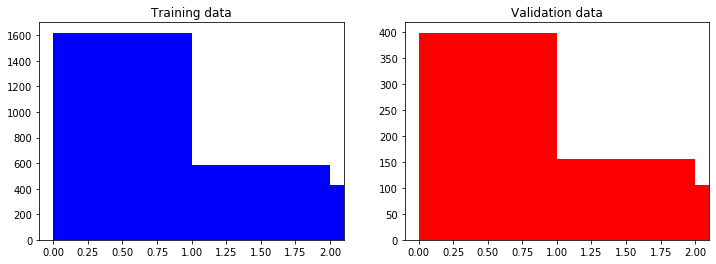

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, new_angles, test_size=0.2)
print("Training data: {}, Validation data : {}".format(len(X_train), len(X_valid)))

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title("Training data")
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title("Validation data")

In [7]:
for a, b in zip(X_train, y_train):
    print(a,b)

crop_img/train_02898_002.png 2
crop_img/train_00906_001.png 1
crop_img/train_02083_002.png 2
crop_img/train_02211_001.png 1
crop_img/train_00923_001.png 1
crop_img/train_00326_002.png 2
crop_img/train_02399_001.png 1
crop_img/train_01376_000.png 0
crop_img/train_00092_000.png 0
crop_img/train_01817_001.png 1
crop_img/train_01550_000.png 0
crop_img/train_00131_000.png 0
crop_img/train_01085_000.png 0
crop_img/train_02811_000.png 0
crop_img/train_01763_000.png 0
crop_img/train_01690_000.png 0
crop_img/train_01092_000.png 0
crop_img/train_00789_000.png 0
crop_img/train_01753_000.png 0
crop_img/train_00183_000.png 0
crop_img/train_00624_000.png 0
crop_img/train_01219_000.png 0
crop_img/train_00048_000.png 0
crop_img/train_01959_002.png 2
crop_img/train_02921_002.png 2
crop_img/train_01804_001.png 1
crop_img/train_00304_000.png 0
crop_img/train_03022_000.png 0
crop_img/train_01369_002.png 2
crop_img/train_02453_002.png 2
crop_img/train_01160_001.png 1
crop_img/train_01050_000.png 0
crop_img

crop_img/train_00761_000.png 0
crop_img/train_00029_002.png 2
crop_img/train_00802_000.png 0
crop_img/train_02568_000.png 0
crop_img/train_02590_000.png 0
crop_img/train_00041_000.png 0
crop_img/train_00913_000.png 0
crop_img/train_02034_001.png 1
crop_img/train_02660_000.png 0
crop_img/train_02142_001.png 1
crop_img/train_02342_001.png 1
crop_img/train_00664_000.png 0
crop_img/train_00125_001.png 1
crop_img/train_00311_000.png 0
crop_img/train_00212_001.png 1
crop_img/train_01703_000.png 0
crop_img/train_02273_000.png 0
crop_img/train_02732_000.png 0
crop_img/train_02947_002.png 2
crop_img/train_02444_002.png 2
crop_img/train_00528_001.png 1
crop_img/train_00832_002.png 2
crop_img/train_02257_002.png 2
crop_img/train_01680_000.png 0
crop_img/train_00226_001.png 1
crop_img/train_03256_000.png 0
crop_img/train_03083_000.png 0
crop_img/train_01163_001.png 1
crop_img/train_02134_002.png 2
crop_img/train_00917_001.png 1
crop_img/train_02574_000.png 0
crop_img/train_02429_000.png 0
crop_img

(66, 200, 3)


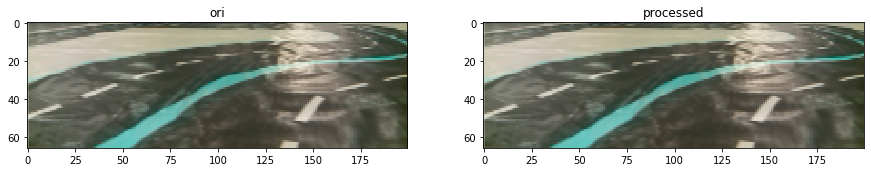

In [8]:
import cv2
def my_imread(image_path):
    image = cv2.imread(image_path)
    return image
def img_preprocess(image):
    image = np.float32(image) / 255.    
    return image
fig, axes = plt.subplots(1,2,figsize=(15,10))
image_ori = my_imread(image_paths[image_index])
image_processed = img_preprocess(image_ori)
axes[0].imshow(image_ori)
axes[0].set_title("ori")
axes[1].imshow(image_processed)
axes[1].set_title("processed")
print(image_ori.shape)

In [9]:
def neural_net():
    model = Sequential()
    model.add(Conv2D(32, (5,5), input_shape=(66,200,3), activation='relu'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (5,5), activation='relu'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (5,5), activation='relu'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    opt = Adam(lr=1e-3)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=opt
    )

    return model

model = neural_net()
print(model.summary())           

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 196, 32)       2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 98, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 98, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 94, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 47, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 47, 64)        0         
_________________________________________

In [10]:
def image_data_generator(image_paths, steering_angles, batch_size):
    while True:
        batch_images = []
        batch_steering_angles = []
        len_imgs = len(image_paths)
        for i in range(batch_size):
            random_index = random.randint(0, len_imgs-1)
            image_path = image_paths[random_index]
            image = my_imread(image_path)
            steering_angle = steering_angles[random_index]

            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
        yield(np.asarray(batch_images), np.asarray(batch_steering_angles))

2633
2


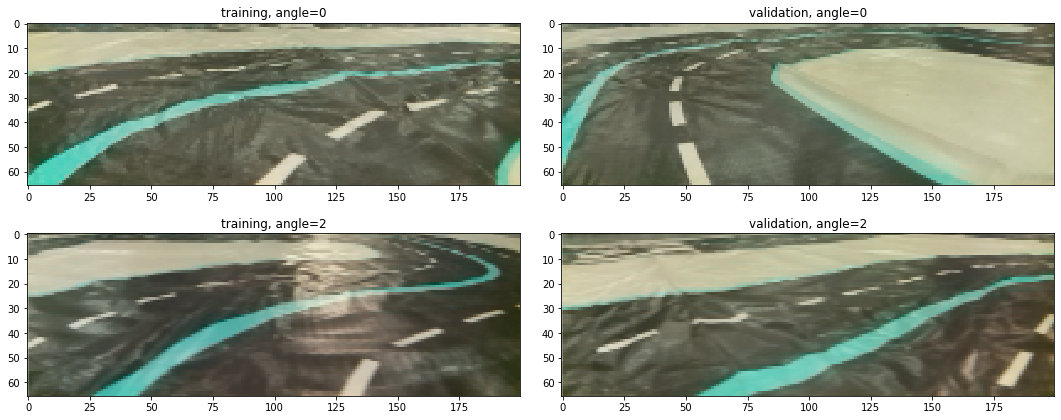

In [11]:
ncol = 2
nrow = 2

print(len(X_train))

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow))

print(len(X_train_batch))
fig, axes = plt.subplots(nrow, ncol, figsize=(15,6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, angle={}".format(y_train_batch[i]))
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, angle={}".format(y_valid_batch[i]))

In [12]:
import datetime 
save_dir = datetime.datetime.now().strftime('%Y%m%d_%H%M')
model_output_dir = os.path.join(save_dir)
os.mkdir(model_output_dir)
print('model_output_dir ', model_output_dir)

model_output_dir  20241201_0805


In [13]:
train_bSize = 16
valid_bSize = 128

# 체크포인트 콜백 설정
checkpoint = 'lane_navigation_'+ save_dir + '.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(model_output_dir, checkpoint),
    verbose=1,
    save_best_only=True   # 가장 좋은 모델만 저장
)

# 훈련 시작
history = model.fit_generator(
    image_data_generator(X_train, y_train, batch_size=train_bSize),
    steps_per_epoch=len(X_train) // train_bSize,
    epochs=150,
    validation_data=image_data_generator(X_valid, y_valid, batch_size=valid_bSize),
    validation_steps=len(X_valid) // valid_bSize,
    verbose=1,
    shuffle=True,
    callbacks=[checkpoint_callback]  # early_stopping 제거
)

history_path = os.path.join(model_output_dir, 'history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

Epoch 1/150
  5/164 [..............................] - ETA: 1:32 - loss: 1.2812
Epoch 00001: val_loss improved from inf to 1.28116, saving model to 20241201_0805/lane_navigation_20241201_0805.h5
164/164 [==============================] - 42s 257ms/step - loss: 2.0509 - val_loss: 1.2812
Epoch 2/150
  5/164 [..............................] - ETA: 1:30 - loss: 0.9277
Epoch 00002: val_loss improved from 1.28116 to 0.92773, saving model to 20241201_0805/lane_navigation_20241201_0805.h5
164/164 [==============================] - 40s 245ms/step - loss: 1.1026 - val_loss: 0.9277
Epoch 3/150
  5/164 [..............................] - ETA: 1:27 - loss: 0.8737
Epoch 00003: val_loss improved from 0.92773 to 0.87371, saving model to 20241201_0805/lane_navigation_20241201_0805.h5
164/164 [==============================] - 40s 241ms/step - loss: 0.9021 - val_loss: 0.8737
Epoch 4/150
  5/164 [..............................] - ETA: 1:29 - loss: 0.7653
Epoch 00004: val_loss improved from 0.87371 to 0.76

  5/164 [..............................] - ETA: 1:28 - loss: 0.6286
Epoch 00025: val_loss improved from 0.64214 to 0.62860, saving model to 20241201_0805/lane_navigation_20241201_0805.h5
164/164 [==============================] - 39s 240ms/step - loss: 0.6874 - val_loss: 0.6286
Epoch 26/150
  5/164 [..............................] - ETA: 1:28 - loss: 0.6720
Epoch 00026: val_loss did not improve from 0.62860
164/164 [==============================] - 40s 241ms/step - loss: 0.6815 - val_loss: 0.6720
Epoch 27/150
  5/164 [..............................] - ETA: 1:28 - loss: 0.6586
Epoch 00027: val_loss did not improve from 0.62860
164/164 [==============================] - 39s 239ms/step - loss: 0.6673 - val_loss: 0.6586
Epoch 28/150
  5/164 [..............................] - ETA: 1:27 - loss: 0.7159
Epoch 00028: val_loss did not improve from 0.62860
164/164 [==============================] - 39s 239ms/step - loss: 0.6579 - val_loss: 0.7159
Epoch 29/150
  5/164 [...........................

Epoch 52/150
  5/164 [..............................] - ETA: 1:28 - loss: 0.7045
Epoch 00052: val_loss did not improve from 0.60360
164/164 [==============================] - 39s 240ms/step - loss: 0.6418 - val_loss: 0.7045
Epoch 53/150
  5/164 [..............................] - ETA: 1:26 - loss: 0.7151
Epoch 00053: val_loss did not improve from 0.60360
164/164 [==============================] - 39s 238ms/step - loss: 0.6663 - val_loss: 0.7151
Epoch 54/150
  5/164 [..............................] - ETA: 1:26 - loss: 0.6646
Epoch 00054: val_loss did not improve from 0.60360
164/164 [==============================] - 39s 238ms/step - loss: 0.6648 - val_loss: 0.6646
Epoch 55/150
  5/164 [..............................] - ETA: 1:28 - loss: 0.6642
Epoch 00055: val_loss did not improve from 0.60360
164/164 [==============================] - 39s 239ms/step - loss: 0.6899 - val_loss: 0.6642
Epoch 56/150
  5/164 [..............................] - ETA: 1:29 - loss: 0.6235
Epoch 00056: val_loss d

  5/164 [..............................] - ETA: 1:29 - loss: 0.6751
Epoch 00079: val_loss did not improve from 0.60360
164/164 [==============================] - 39s 239ms/step - loss: 0.6347 - val_loss: 0.6751
Epoch 80/150
  5/164 [..............................] - ETA: 1:28 - loss: 0.6073
Epoch 00080: val_loss did not improve from 0.60360
164/164 [==============================] - 39s 239ms/step - loss: 0.6243 - val_loss: 0.6073
Epoch 81/150
  5/164 [..............................] - ETA: 1:27 - loss: 0.6771
Epoch 00081: val_loss did not improve from 0.60360
164/164 [==============================] - 39s 239ms/step - loss: 0.6398 - val_loss: 0.6771
Epoch 82/150
  5/164 [..............................] - ETA: 1:29 - loss: 0.6741
Epoch 00082: val_loss did not improve from 0.60360
164/164 [==============================] - 39s 239ms/step - loss: 0.6456 - val_loss: 0.6741
Epoch 83/150
  5/164 [..............................] - ETA: 1:28 - loss: 0.6860
Epoch 00083: val_loss did not improv

  5/164 [..............................] - ETA: 1:27 - loss: 0.7308
Epoch 00106: val_loss did not improve from 0.60360
164/164 [==============================] - 39s 238ms/step - loss: 0.6118 - val_loss: 0.7308
Epoch 107/150
  5/164 [..............................] - ETA: 1:27 - loss: 0.7274
Epoch 00107: val_loss did not improve from 0.60360
164/164 [==============================] - 39s 239ms/step - loss: 0.6234 - val_loss: 0.7274
Epoch 108/150
  5/164 [..............................] - ETA: 1:26 - loss: 0.7316
Epoch 00108: val_loss did not improve from 0.60360
164/164 [==============================] - 39s 238ms/step - loss: 0.6221 - val_loss: 0.7316
Epoch 109/150
  5/164 [..............................] - ETA: 1:28 - loss: 0.7731
Epoch 00109: val_loss did not improve from 0.60360
164/164 [==============================] - 39s 239ms/step - loss: 0.6357 - val_loss: 0.7731
Epoch 110/150
  5/164 [..............................] - ETA: 1:27 - loss: 0.7962
Epoch 00110: val_loss did not im

  5/164 [..............................] - ETA: 1:28 - loss: 0.8362
Epoch 00133: val_loss did not improve from 0.60360
164/164 [==============================] - 39s 238ms/step - loss: 0.5938 - val_loss: 0.8362
Epoch 134/150
  5/164 [..............................] - ETA: 1:27 - loss: 0.7541
Epoch 00134: val_loss did not improve from 0.60360
164/164 [==============================] - 39s 239ms/step - loss: 0.6066 - val_loss: 0.7541
Epoch 135/150
  5/164 [..............................] - ETA: 1:28 - loss: 0.7044
Epoch 00135: val_loss did not improve from 0.60360
164/164 [==============================] - 39s 239ms/step - loss: 0.6274 - val_loss: 0.7044
Epoch 136/150
  5/164 [..............................] - ETA: 1:29 - loss: 0.8478
Epoch 00136: val_loss did not improve from 0.60360
164/164 [==============================] - 39s 239ms/step - loss: 0.5972 - val_loss: 0.8478
Epoch 137/150
  5/164 [..............................] - ETA: 1:26 - loss: 0.8508
Epoch 00137: val_loss did not im

(66, 200, 3)
[0.6261501  0.37176737 0.00208253]
0


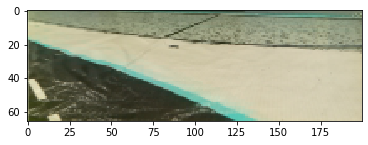

In [14]:
img_path = X_valid[0]
image = my_imread(img_path)
steering_angle = steering_angles[0]
image = img_preprocess(image)
print(image.shape)
print(model.predict(np.expand_dims(image, 0))[0])
print(np.argmax(model.predict(np.expand_dims(image, 0))[0]))
plt.imshow(image)

20241201_0805


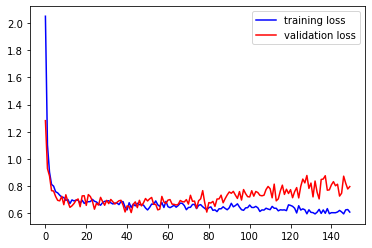

In [15]:
print(model_output_dir)

history_path = os.path.join(model_output_dir, 'history.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

plt.plot(history['loss'], color='blue')
plt.plot(history['val_loss'], color='red')
plt.legend(['training loss', 'validation loss'])